# Analyzing Tau Features

In [13]:
import pandas as pd

# Read the tau output CSV
tau_data = pd.read_csv('../cpp_substructure/tau_output.csv')

# Display the first few rows
tau_data.head()

,event_id,jet_id,pt,eta,phi,tau1,tau2,tau3
0,0,0,545.948,-1.001000,0.102569,0.070973,0.053303,0.044378
1,1,0,539.619,-0.729597,5.274140,0.081049,0.037583,0.032275
2,2,0,506.208,1.633120,1.573420,0.045495,0.040290,0.034903
3,3,0,514.297,0.569754,5.210060,0.060095,0.044260,0.036035
4,4,0,541.014,-0.591679,6.266800,0.068896,0.035701,0.030003


In [14]:
import numpy as np

# Load the original labels
data = np.load("../datasets/QG_jets_withbc_0.npz")
y_val = data["y"]

# Double-check shape
print("Labels loaded:", y_val.shape)

# Add the label column
tau_data["label"] = y_val[:len(df_tau)]

# Optional: Add a human-readable version
tau_data["label_name"] = df_tau["label"].map({1: "Quark", 0: "Gluon"})

# Check a few rows
tau_data.head()

Labels loaded: (100000,)


,event_id,jet_id,pt,eta,phi,tau1,tau2,tau3,label,label_name
0,0,0,545.948,-1.001000,0.102569,0.070973,0.053303,0.044378,0.0,Gluon
1,1,0,539.619,-0.729597,5.274140,0.081049,0.037583,0.032275,0.0,Gluon
2,2,0,506.208,1.633120,1.573420,0.045495,0.040290,0.034903,0.0,Gluon
3,3,0,514.297,0.569754,5.210060,0.060095,0.044260,0.036035,0.0,Gluon
4,4,0,541.014,-0.591679,6.266800,0.068896,0.035701,0.030003,0.0,Gluon


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tau_distribution(df, feature, label_column="label_name"):
    """Plot the distribution of a tau feature (tau1, tau2, etc.) for Quark and Gluon jets."""
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue=label_column, kde=True, stat="density", common_norm=False)
    plt.title(f"Distribution of {feature} for Quark vs Gluon")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

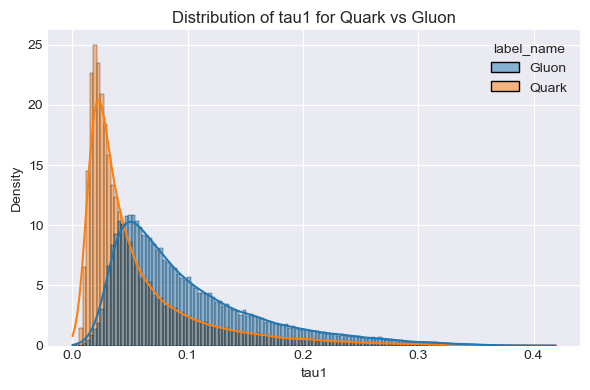

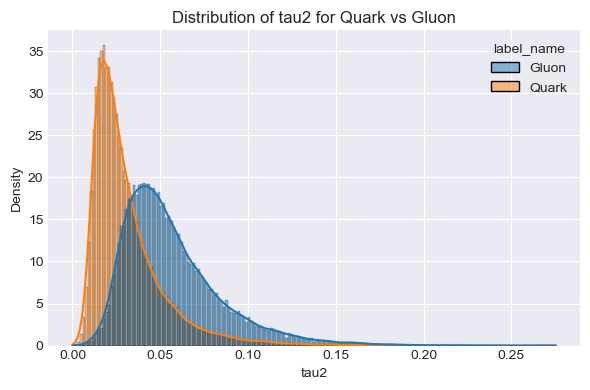

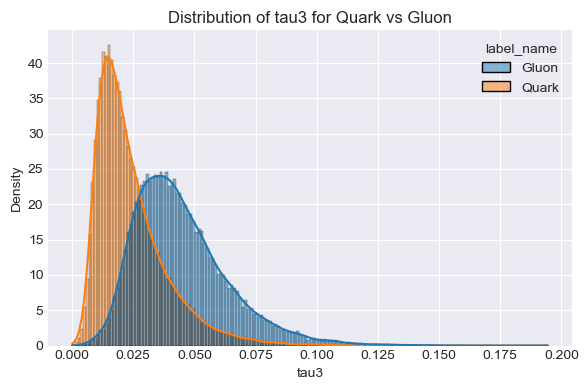

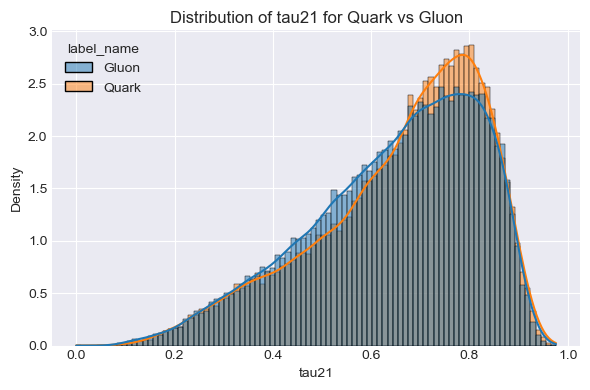

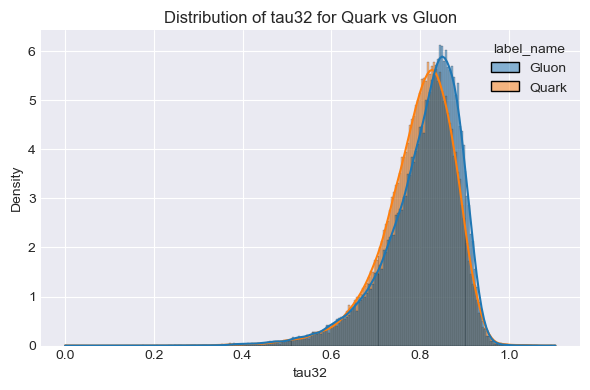

In [20]:
# Plotting tau1, tau2, tau3

for tau in ["tau1", "tau2", "tau3"]:
    plot_tau_distribution(tau_data, tau)

# Adding τ21 and τ32 to the dataframe
tau_data["tau21"] = np.where(tau_data["tau1"] > 0, tau_data["tau2"] / tau_data["tau1"], 0)
tau_data["tau32"] = np.where(tau_data["tau2"] > 0, tau_data["tau3"] / tau_data["tau2"], 0)

for ratio in ["tau21", "tau32"]:
    plot_tau_distribution(tau_data, ratio)

In [21]:
import os
os.listdir("../cpp_substructure")

['compute_tauN.cpp',
 'Makefile',
 'compute_tauN',
 'tau_output.csv',
 'jets_particles.txt']

In [22]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Features to summarize
tau_vars = ["tau1", "tau2", "tau3", "tau21", "tau32"]

# Create a summary dictionary
summary_stats = {
    "Feature": [],
    "Class": [],
    "Mean": [],
    "Std": [],
    "Skewness": [],
    "Kurtosis": []
}

# Loop over each tau variable and class
for tau in tau_vars:
    for label, name in zip([1, 0], ["Quark", "Gluon"]):
        values = tau_data[tau_data["label"] == label][tau]
        summary_stats["Feature"].append(tau)
        summary_stats["Class"].append(name)
        summary_stats["Mean"].append(values.mean())
        summary_stats["Std"].append(values.std())
        summary_stats["Skewness"].append(skew(values))
        summary_stats["Kurtosis"].append(kurtosis(values))

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary_stats)
summary_df.round(4)

,Feature,Class,Mean,Std,Skewness,Kurtosis
0,tau1,Quark,0.0568,0.0523,2.1529,5.2254
1,tau1,Gluon,0.0992,0.0632,1.3478,1.6435
2,tau2,Quark,0.0312,0.0211,2.2483,7.7735
3,tau2,Gluon,0.0569,0.0280,1.4496,3.1339
4,tau3,Quark,0.0243,0.0147,1.7382,4.7280
5,tau3,Gluon,0.0446,0.0192,1.1116,2.0365
6,tau21,Quark,0.6608,0.1707,-0.7870,-0.0379
7,tau21,Gluon,0.6470,0.1721,-0.6491,-0.2388
8,tau32,Quark,0.7952,0.0842,-1.1664,2.9342
9,tau32,Gluon,0.8061,0.0873,-1.3138,2.5867


In [29]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np

def plot_cdf_and_ks(df, feature_name, label_col="label", label_names={1: "Quark", 0: "Gluon"}):
    """
    Plot empirical CDFs and compute KS-statistic for a tau feature (e.g., tau1, tau21, tau32).
    """
    # Extract values
    quark_values = df[df[label_col] == 1][feature_name].dropna().values
    gluon_values = df[df[label_col] == 0][feature_name].dropna().values

    # Sort for empirical CDF
    quark_sorted = np.sort(quark_values)
    gluon_sorted = np.sort(gluon_values)

    quark_cdf = np.arange(1, len(quark_sorted)+1) / len(quark_sorted)
    gluon_cdf = np.arange(1, len(gluon_sorted)+1) / len(gluon_sorted)

    # Create LaTeX-style label
    latex_label = feature_name.replace("tau", r"\tau_")

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(quark_sorted, quark_cdf, label=label_names[1], color='blue')
    plt.plot(gluon_sorted, gluon_cdf, label=label_names[0], color='red')
    plt.xlabel(f"${latex_label}$", fontsize=14)
    plt.ylabel("Empirical CDF")
    plt.title(f"Empirical CDF of ${latex_label}$ for Quark vs Gluon Jets")
    plt.legend()
    plt.grid(True)
    plt.show()

    # KS Test
    ks_stat, p_val = ks_2samp(quark_values, gluon_values)
    print(f"KS Statistic ({feature_name}): {ks_stat:.4f}")
    print(f"P-value: {p_val:.4e}")

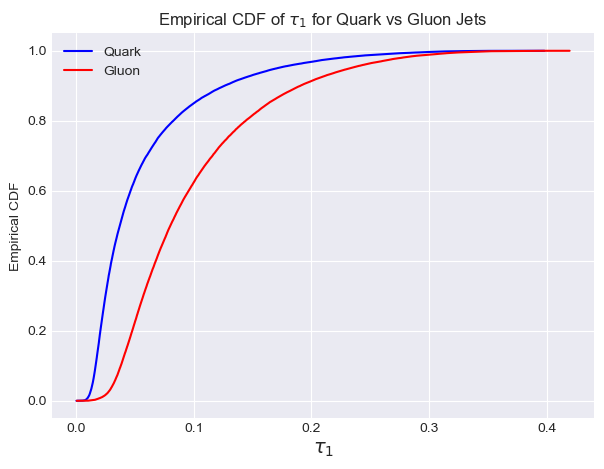

KS Statistic (tau1): 0.4180
P-value: 0.0000e+00


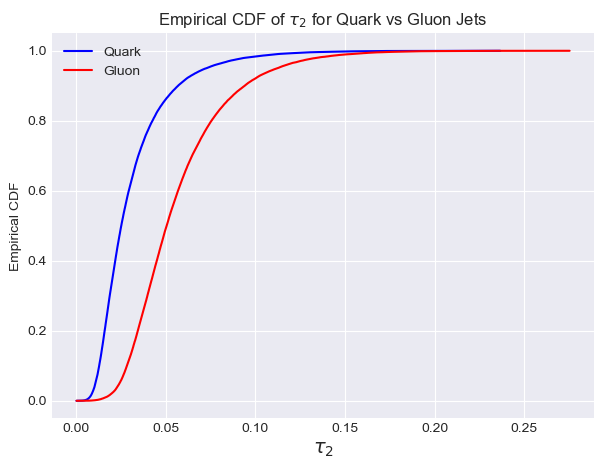

KS Statistic (tau2): 0.4975
P-value: 0.0000e+00


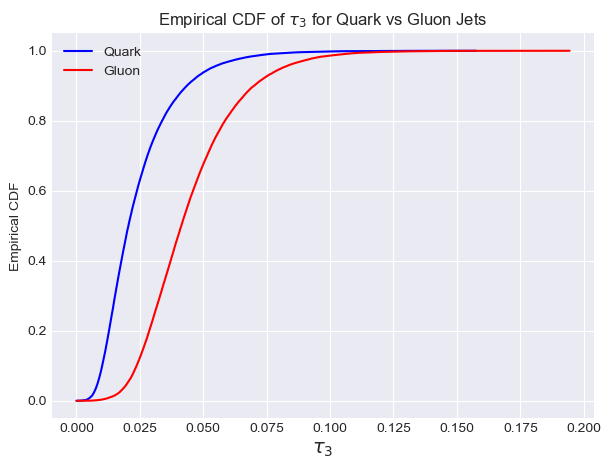

KS Statistic (tau3): 0.5173
P-value: 0.0000e+00


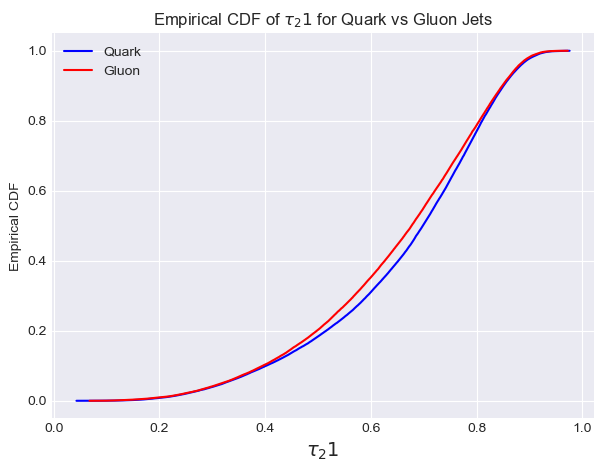

KS Statistic (tau21): 0.0507
P-value: 3.3236e-56


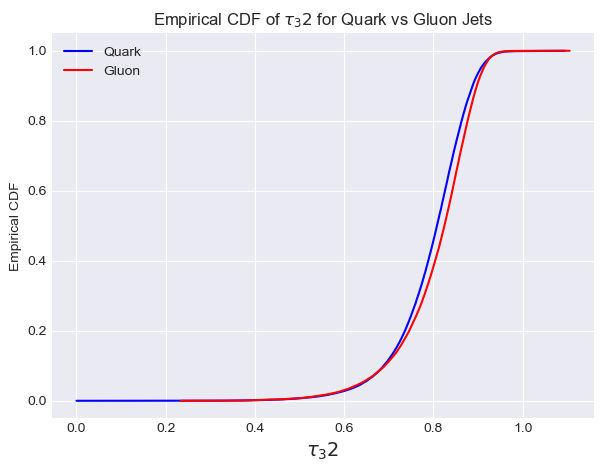

KS Statistic (tau32): 0.0957
P-value: 1.3918e-199


In [30]:
plot_cdf_and_ks(tau_data, "tau1")
plot_cdf_and_ks(tau_data, "tau2")
plot_cdf_and_ks(tau_data, "tau3")
plot_cdf_and_ks(tau_data, "tau21")
plot_cdf_and_ks(tau_data, "tau32")

### Entropy Analysis

In [31]:
import pandas as pd
import numpy as np

# Load the entropy values
entropy_file = "../cpp_substructure/entropy_output.csv"
entropy_values = np.loadtxt(entropy_file, delimiter=",", skiprows=1)  # Skip header

# Load original labels
data = np.load("../datasets/QG_jets_withbc_0.npz")
y_val = data["y"]

# Create a new DataFrame for entropy analysis
entropy_data = pd.DataFrame({
    "entropy": entropy_values,
    "label": y_val[:len(entropy_values)]  # align labels
})

# Map label to names
entropy_data["label_name"] = entropy_data["label"].map({1: "Quark", 0: "Gluon"})

# Check
entropy_data.head()

,entropy,label,label_name
0,3.030184,0.0,Gluon
1,2.465690,0.0,Gluon
2,2.743416,0.0,Gluon
3,3.094521,0.0,Gluon
4,3.209716,0.0,Gluon


/var/folders/8d/mq82lbs54414nftm7vm34p7w0000gn/T/ipykernel_15532/2334397159.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Jet Type")


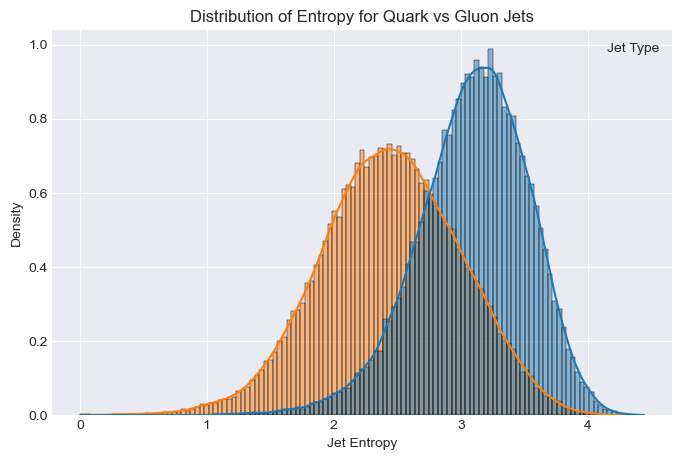

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=entropy_data, x="entropy", hue="label_name", kde=True, stat="density", common_norm=False)
plt.title(r"Distribution of Entropy for Quark vs Gluon Jets")
plt.xlabel(r"Jet Entropy")
plt.ylabel("Density")
plt.legend(title="Jet Type")
plt.show()

In [33]:
from scipy.stats import ks_2samp

# Split entropy values based on label
entropy_quark = entropy_data[entropy_data["label"] == 1]["entropy"]
entropy_gluon = entropy_data[entropy_data["label"] == 0]["entropy"]

# KS Test
ks_stat, p_value = ks_2samp(entropy_quark, entropy_gluon)

print(f"KS Statistic (entropy): {ks_stat:.4f}")
print(f"P-value: {p_value:.4e}")

KS Statistic (entropy): 0.5058
P-value: 0.0000e+00
